In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torch.autograd import Variable

# Define the custom dataset class
class PaddleDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.tensor(self.data.iloc[idx, :8], dtype=torch.float32)
        label = torch.tensor(self.data.iloc[idx, 8:13].values, dtype=torch.float32)
        return features, label

# Define the neural network model
class PaddleClassifier(nn.Module):
    def __init__(self):
        super(PaddleClassifier, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Set the device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
# Load the data
data = pd.read_csv("TrainingDataReorg.tsv", sep="\t")
train_dataset = PaddleDataset(data)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [17]:
# Initialize the model, loss function, and optimizer
model = PaddleClassifier().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

model_path = "paddle_classifier.pth"
onnx_path = "paddle_classifier.onnx"

# Load the model from disk if it exists
if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    print("Model loaded from disk")

In [19]:
# Train the model
epochs = 30
for epoch in range(epochs):
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # if (epoch + 1) % 10 == 0:
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

print("Training complete")

Epoch [1/30], Loss: 0.1698
Epoch [2/30], Loss: 0.0876
Epoch [3/30], Loss: 0.0635
Epoch [4/30], Loss: 0.0580
Epoch [5/30], Loss: 0.0639
Epoch [6/30], Loss: 0.0612
Epoch [7/30], Loss: 0.0537
Epoch [8/30], Loss: 0.0967
Epoch [9/30], Loss: 0.0241
Epoch [10/30], Loss: 0.0585
Epoch [11/30], Loss: 0.0270
Epoch [12/30], Loss: 0.0419
Epoch [13/30], Loss: 0.0482
Epoch [14/30], Loss: 0.0439
Epoch [15/30], Loss: 0.0240
Epoch [16/30], Loss: 0.0368
Epoch [17/30], Loss: 0.0225
Epoch [18/30], Loss: 0.6929
Epoch [19/30], Loss: 0.0226
Epoch [20/30], Loss: 0.0531
Epoch [21/30], Loss: 0.0190
Epoch [22/30], Loss: 0.0282
Epoch [23/30], Loss: 0.0447
Epoch [24/30], Loss: 0.0527
Epoch [25/30], Loss: 0.0285
Epoch [26/30], Loss: 0.0324
Epoch [27/30], Loss: 0.0269
Epoch [28/30], Loss: 0.0283
Epoch [29/30], Loss: 0.0347
Epoch [30/30], Loss: 0.0312
Training complete


In [20]:
# Save the trained model to disk
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Move the model back to CPU before exporting to ONNX
model.to("cpu")

# Export the model to ONNX format
dummy_input = Variable(torch.randn(1, 8))
torch.onnx.export(model, dummy_input, onnx_path, verbose=True, input_names=["input"], output_names=["output"])

# Check the ONNX model
#onnx_model = torch.onnx.load(onnx_path)
#onnx.checker.check_model(onnx_model)
print(f"ONNX model saved to {onnx_path}")

Model saved to paddle_classifier.pth
ONNX model saved to paddle_classifier.onnx


In [21]:
#test model with set inputs
import numpy as np

def predict(model, input_data):
    model.eval()
    with torch.no_grad():
        model.to(device)
        input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=0)
        predicted_class = torch.argmax(probabilities).item()
    return probabilities, predicted_class

# Example input data
input_data = [2.02, 28.22204, 0.4549797, 0, -0.377058, -0.2713, -0.4834, -3.15]  # Replace this with your own input data
probabilities, predicted_class = predict(model, input_data)

# Map the predicted_class index to the corresponding label
class_labels = ['MyPaddleIsRight', 'MyPaddleIsLeft', 'MyPaddleIsStill']
predicted_label = class_labels[predicted_class]

print(f"Probabilities: {probabilities.cpu().numpy()}")
print(f"Predicted class index: {predicted_class}")
print(f"Predicted class label: {predicted_label}")


Probabilities: [0.12449959 0.13521875 0.40022224 0.15066096 0.18939844]
Predicted class index: 2
Predicted class label: MyPaddleIsStill


In [81]:
def evaluate_with_labels(model, dataloader):
    model.eval()
    all_predicted_labels = []
    all_correct_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predicted_labels.extend(predicted.cpu().numpy())
            all_correct_labels.extend(labels.cpu().numpy())

    return all_predicted_labels, all_correct_labels


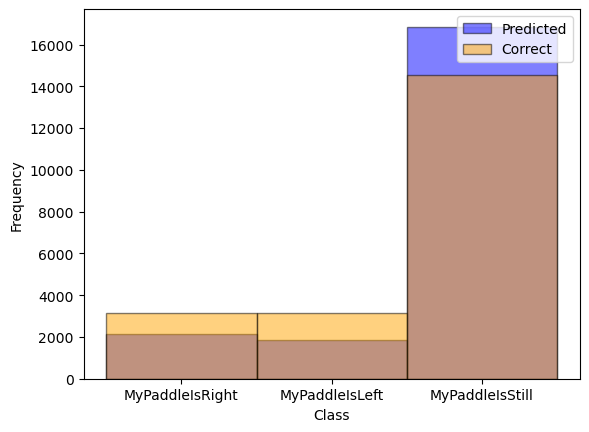

In [83]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = PaddleDataset(train_data)
val_dataset = PaddleDataset(val_data)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Evaluate the model on the validation set and get predicted and correct labels
predicted_labels, correct_labels = evaluate_with_labels(model, val_dataloader)

# Create histograms for predicted and correct labels
bins = np.arange(4) - 0.5  # Shift the bins by 0.5 to center the bars
plt.hist(predicted_labels, bins, alpha=0.5, label="Predicted", color="blue", edgecolor="black")
plt.hist(correct_labels, bins, alpha=0.5, label="Correct", color="orange", edgecolor="black")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(range(3), ['MyPaddleIsRight', 'MyPaddleIsLeft', 'MyPaddleIsStill'])
plt.legend(loc="upper right")
plt.show()